In [54]:
from dotenv import load_dotenv
load_dotenv(dotenv_path='.env')

import os

# Getting the Data

In [2]:
from langchain.document_loaders import PyPDFLoader

file_path = "./other_data/_the_Dementia_Wars__Santa's_Salvation_.pdf"

book_loader = PyPDFLoader(file_path)
book_data = book_loader.load_and_split()

# Create the Graph Representation

In [4]:
from langchain.indexes import GraphIndexCreator
from langchain.llms import OpenAI

llm = OpenAI()
index_creator = GraphIndexCreator(llm=llm)
graph = index_creator.from_text(book_data[20].page_content)

graph.get_triples()

[('Chapter 1', "Santa Claus's Call to Arms", 'is called'),
 ('Santa Claus', 'heavily', 'sighs'),
 ('Santa Claus', 'Rudolph', 'tells'),
 ('Santa Claus', 'what does this mean for Christmas?', 'responds'),
 ('Santa Claus', 'gratefully', 'smiles'),
 ('Santa Claus', 'his allies', 'turns to'),
 ('Santa Claus', 'we will fight this war together', 'declares'),
 ('Santa Claus', 'our mission remains unchanged', 'says'),
 ('Rudolph', 'with determination', 'steps forward'),
 ('Reindeer', 'one by one', 'nod in agreement'),
 ('Mrs. Claus', 'her voice is filled with compassion', 'steps forward')]

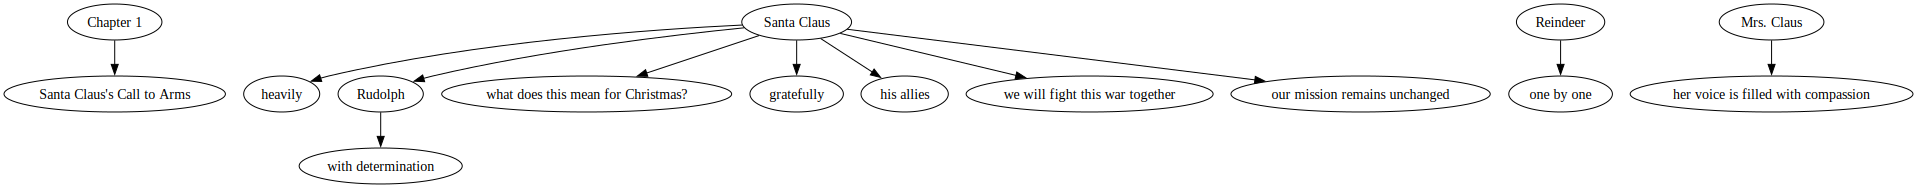

In [5]:
from IPython.display import SVG
graph.draw_graphviz(path="graph.svg")
SVG("graph.svg")


In [6]:
graphs = [
    index_creator.from_text(doc.page_content)
    for doc in book_data
]

In [36]:
import networkx as nx

graph_nx = graphs[0]._graph
for g in graphs[1:]:
    graph_nx = nx.compose(graph_nx, g._graph)

graph_nx
graph_nx.number_of_nodes()

1941

In [37]:
from langchain.graphs.networkx_graph import NetworkxEntityGraph

graph = NetworkxEntityGraph(graph_nx)
graph

In [45]:
#graph.draw_graphviz(path="graph.pdf", prog="fdp")

# Augmenting LLMs with a Knowledge Base

In [47]:
from langchain.chains import GraphQAChain
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(temperature=0)

chain = GraphQAChain.from_llm(
    llm=llm,
    graph=graph,
    verbose=True,
)

chain.run("What is happening in the North Pole?")



> Entering new GraphQAChain chain...
Entities Extracted:
North Pole
Full Context:
North Pole crumbled under President Harrison's delusions
North Pole had been defended spirit of Christmas
North Pole becomes battleground
North Pole is secure once again
North Pole is in danger of the war
North Pole is the fate of Christmas
North Pole begins to regain former glory

> Finished chain.


'The North Pole is experiencing a war or conflict that is endangering the fate of Christmas. However, it is also being defended and has regained some of its former glory.'

In [49]:
chain.run("Who is Timmy?")



> Entering new GraphQAChain chain...
Entities Extracted:
Timmy
Full Context:
Timmy watched in awe
Timmy watched in fear
Timmy saw hope
Timmy stands alongside Santa Claus
Timmy stumbles through the desolate and snow-covered landscape
Timmy spots a group of figures
Timmy runs towards them
Timmy nods a mixture of relief and hope
Timmy watched with wide eyes
Timmy felt surge of courage
Timmy vowed to help
Timmy was caught in the crossfire
Timmy felt a glimmer of hope
Timmy remembered the stories his parents had told him about Santa Claus and the magic of Christmas
Timmy believed that there was still a chance for peace
Timmy was searching for allies of Santa Claus
Timmy had found the allies he had been searching for
Timmy caught sight of a familiar figure
Timmy had been searching for the allies he had been searching for
Timmy trudged through the snow
Timmy called out for Santa Claus to help him
Timmy looked up at his newfoun
Timmy encountered the war's devastation
Timmy saw the place he h

'Timmy is a young boy who is determined to protect the spirit of Christmas and help Santa Claus and his allies.'

# Using the Diffbot Graph Transformer

In [55]:
from langchain_experimental.graph_transformers.diffbot import DiffbotGraphTransformer

diffbot_nlp = DiffbotGraphTransformer(
    diffbot_api_key=os.getenv("DIFFBOT_API_KEY"),
)

In [59]:
from langchain.document_loaders import WikipediaLoader

query = "Warren Buffett"

raw_docs = WikipediaLoader(query=query).load()

In [60]:
graph_docs = diffbot_nlp.convert_to_graph_documents(raw_docs)

In [61]:
graph_docs[0].relationships

[Relationship(source=Node(id='http://www.wikidata.org/entity/Q217583', type='Organization'), target=Node(id='http://www.wikidata.org/entity/Q47213', type='Person'), type='CHIEF_EXECUTIVE_OFFICER', properties={'evidence': 'Warren Edward Buffett ( BUF-it; born August 30, 1930) is an American businessman, investor, and philanthropist who currently serves as the co-founder, chairman and CEO of Berkshire Hathaway.', 'isCurrent': 'true'}),
 Relationship(source=Node(id='http://www.wikidata.org/entity/Q217583', type='Organization'), target=Node(id='http://www.wikidata.org/entity/Q47213', type='Person'), type='FOUNDED_BY', properties={'evidence': 'Warren Edward Buffett ( BUF-it; born August 30, 1930) is an American businessman, investor, and philanthropist who currently serves as the co-founder, chairman and CEO of Berkshire Hathaway.'}),
 Relationship(source=Node(id='http://www.wikidata.org/entity/Q723488', type='Person'), target=Node(id='Leila', type='Person'), type='SOCIAL_RELATIONSHIP', pro

In [62]:
book_graph = diffbot_nlp.convert_to_graph_documents(book_data)

# Creating a Local Graph Database

In [63]:
from langchain.graphs import Neo4jGraph

graph_db = Neo4jGraph(
    url="bolt://localhost:7687",
    username="neo4j",
    password="pleaseletmein"
)

In [64]:
graph_db.add_graph_documents(book_graph)

In [65]:
graph_db.refresh_schema()

# Augmenting an LLM with the Graph Database

In [66]:
from langchain.chains import GraphCypherQAChain

cypher_llm = ChatOpenAI(temperature=0, model_name="gpt-4")
qa_llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")

chain = GraphCypherQAChain.from_llm(
    cypher_llm=cypher_llm,
    qa_llm=qa_llm,
    graph=graph_db,
    verbose=True,
)

In [67]:
from langchain.callbacks import StdOutCallbackHandler


chain.run("What is happening in the North Pole?", callbacks=[StdOutCallbackHandler()])



> Entering new GraphCypherQAChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Task:Generate Cypher statement to query a graph database.
Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.
Schema:
Node properties are the following:
Person {id: STRING, name: STRING},Location {id: STRING, name: STRING},Skill {id: STRING, name: STRING},Organization {name: STRING, id: STRING}
Relationship properties are the following:
PERSON_LOCATION {evidence: STRING},INTERESTED_IN {evidence: STRING},SOCIAL_RELATIONSHIP {evidence: STRING},ROMANTIC_RELATIONSHIP {evidence: STRING},EMPLOYEE_OR_MEMBER_OF {evidence: STRING, isCurrent: STRING}
The relationships are the following:
(:Person)-[:PERSON_LOCATION]->(:Location),(:Person)-[:INTERESTED_IN]->(:Skill),(:Person)-[:ROMANTIC_RELATIONSHIP]->(:Person),(:Person)-[:SOCIAL_RELATIONSHIP]->(:Person),(:Person)-[:EMPLOYEE_OR_MEMBER_O

"I'm sorry, but I don't have any information on what is currently happening in the North Pole."

In [68]:
chain.run("Who is Timmy?", callbacks=[StdOutCallbackHandler()])



> Entering new GraphCypherQAChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Task:Generate Cypher statement to query a graph database.
Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.
Schema:
Node properties are the following:
Person {id: STRING, name: STRING},Location {id: STRING, name: STRING},Skill {id: STRING, name: STRING},Organization {name: STRING, id: STRING}
Relationship properties are the following:
PERSON_LOCATION {evidence: STRING},INTERESTED_IN {evidence: STRING},SOCIAL_RELATIONSHIP {evidence: STRING},ROMANTIC_RELATIONSHIP {evidence: STRING},EMPLOYEE_OR_MEMBER_OF {evidence: STRING, isCurrent: STRING}
The relationships are the following:
(:Person)-[:PERSON_LOCATION]->(:Location),(:Person)-[:INTERESTED_IN]->(:Skill),(:Person)-[:ROMANTIC_RELATIONSHIP]->(:Person),(:Person)-[:SOCIAL_RELATIONSHIP]->(:Person),(:Person)-[:EMPLOYEE_OR_MEMBER_O

'Timmy is a person whose name is Timmy.'